# DFT for one dimensional systems

There are many implementations of DFT around, e.g. abint, Vasp, .... But all of these codes are very cumbersome to understand, because there is a lot of functionality implemented. The problem is that, in learning DFT this is an overwhelming amount of information, hard to process for newcomers. This is why often these codes are used like a black box. (Which may lead to errors in using the code.) Here we want to present a very simple implementation, which introduces already the basic variables. This notebook shows the full implementation of DFT, which aims to be as short (and readable) as possible. 
Since it is interactive, the reader sees at any step what is going on. Furthermore the code invites to play around.

## Setting the scene: loading libaries and defining input parameters

In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.special import erfcx

In [2]:
neuc = 1  # number of electrons
rs = 1    # average rs value 
nG = 20   # number of G vectors 
nk = 40   # number of k vectors, should be multiple of 4 
nB = 10   # number of bands
kT=0.001  # Temperature for FD distribution in Ry

In [3]:
a=2*neuc     # length of the unit cell
ne=neuc*nk   # number of electrons in the "super cell"
kF=np.pi/4   # the Fermi wave vector corresponding to the mean density of the system
rho0=neuc/a  # mean density
deltaG=2*np.pi/a          # reciprocal lattice 
x=np.arange(0,a,a/nG)     # real space grid
kvec=np.arange(-deltaG*(1./2.-1./nk),deltaG/2+0.000001,deltaG/nk)   # k-point mesh
Gtemp=np.arange(0,nG,1)   
G=((Gtemp+nG/2)%nG-nG/2)*deltaG   # reciprocal lattice grid

In [4]:
def FFT(x):
    "The fourier transform(gives real valued results if symetric)"
    tmp=fft(x)/nG
    if abs(np.imag(tmp)).max()<1e-10:
        res=np.real(tmp)
    else:
        #print("large imaginary part")
        res=tmp        
    return res

In [5]:
def IFFT(x):
    "The inverse fourier transform(gives real valued results if symetric)"
    tmp=ifft(x)*nG
    if abs(np.imag(tmp)).max()<1e-10:
        res=np.real(tmp)
    else:
        #print("large imaginary part")
        res=tmp        
    return res

In [6]:
Vext=np.exp(1j*x*deltaG)+np.exp(-1j*x*deltaG)

In [7]:
VextG=FFT(Vext)

## Solving the noninteracting Schroedinger equation

In [8]:
def kin(k):
    "The kinetic energy array (for all G vectors) for a certain k-point k"
    res=np.diag((k+G)**2/rs**2)
    return res

In [9]:
def Vmat(V):
    "Creates the potential matrix in momentum space"
    tmp=np.zeros((nG,nG))
    tmp=tmp+np.diag(np.ones(nG)*V[[0]])
    for i in range(1,nG):
        tmp=tmp+np.diag(np.ones(nG-i)*V[nG-i],i)
        tmp=tmp+np.diag(np.ones(nG-i)*V[i],-i)
    return tmp

In [10]:
Vin=Vmat(VextG)

In [11]:
eign,v=LA.eig(kin(0)+1*Vin)

In [12]:
def schroed(V):
    "solves the non interacting Schroedinger equation in momentum space"
    bandst=np.empty((nk,nB))
    wfk=np.empty((nk,nG,nB),dtype=complex)
    #wfk=np.array(wfk,dtype=complex)
    for i in range(nk):
        eig,v=LA.eigh(kin(kvec[i])+V)
        bandst[i]=eig[0:nB]
        wfk[i]=v[:,0:nB]
        
    return bandst, wfk

In [13]:
bandst,wfk=schroed(Vin)

we have to guess the Fermi level. This is done in a heuristic way

In [14]:
if neuc%2==1:
    fband=int((neuc+1)/2)-1
    fermilevel=bandst[int(nk/4)-1,fband]   #nk should be a multiple of 4
    print(fermilevel)
    print(fband,nk/4)
else:
    fband=int(neuc/2)-1
    fermilevel=0.5*(bandst[:,fband].max() + bandst[:,fband+1].min() )
    print(fermilevel)
    print(fband,nk/4)

0.356639178735
0 10.0


In [15]:
def occupation(eigenvalue):
    "calculates occupation numbers"
    if (eigenvalue-fermilevel)/kT>20:
        res=0.
    elif (eigenvalue-fermilevel)/kT<-20:
        res=1.
    elif -20<(eigenvalue-fermilevel)/kT < 20:
        res=1/(np.exp((eigenvalue-fermilevel)/kT)+1)

    return res

In [16]:
occ=np.empty((nk,nB))

In [17]:
for ik in range(nk):
    for jn in range(nB):
        occ[ik,jn]=2*occupation(bandst[ik,jn])

The next is to check whether the fermilevel has been choosen properly. If so the resulting number should be close to zero.

In [18]:
sum=0.
for ik in range(nk):
    for jn in range(nB):
        sum=sum+occ[ik,jn]
sum-ne

2.8421709430404007e-14

In [19]:
def calc_rho(occ,wfk):
    rho=np.zeros(nG)
    for ik in range(nk):
        for jn in range(nB):
            rho=rho+2*occ[ik,jn]*np.abs(IFFT(wfk[ik,:,jn]))**2
    rho=rho/a/nk/2   #prefactor not yet clear
    return rho

In [20]:
rho=calc_rho(occ,wfk)
rho

array([ 0.3029704 ,  0.31051928,  0.33313723,  0.37053922,  0.42163216,
        0.4837664 ,  0.55208778,  0.61939758,  0.67688214,  0.71577751,
        0.72955096,  0.71577751,  0.67688214,  0.61939758,  0.55208778,
        0.4837664 ,  0.42163216,  0.37053922,  0.33313723,  0.31051928])

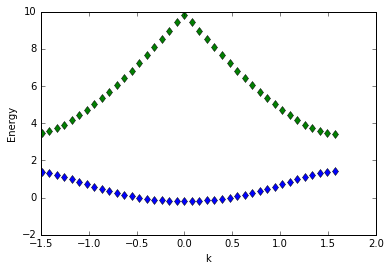

In [21]:
plt.plot(kvec,bandst[:,0:2],"d")
plt.xlabel("k")
plt.ylabel("Energy")

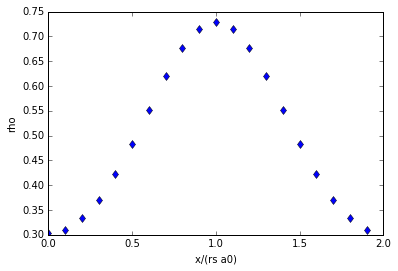

In [22]:
plt.plot(x,rho,"d")
plt.xlabel("x/(rs a0)")
plt.ylabel("rho")

## Calculating the exchange correlation potential

The exchange and correlation energy are defined with respect to an interaction. In 1D the use of the bare Coulomb interaction is not a good idea. A physically motivated interaction is that of electrons in an harmonic trap. In order, for the 1D limit to be valid, the first excited states perpenticular to the wire has to be well separated from the ground state. A potential derived from this model is widely used in the literature (M. Casula, Asgari).
b ...  is a parameter which d

In [23]:
def v(r,rs):
    b=0.1/rs
    #res=np.exp(r**2/4/b**2)*erfc(abs(r)/2/b)* np.sqrt(np.pi)/b/rs
    res=erfcx(abs(r)/2/b)* np.sqrt(np.pi)/b/rs
    return res

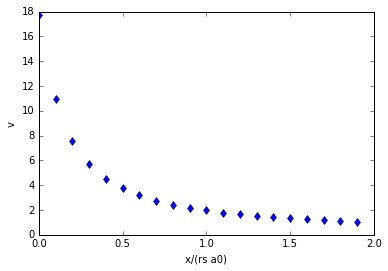

In [24]:
plt.plot(x,v(x,rs),"d")
plt.xlabel("x/(rs a0)")
plt.ylabel("v")

In [25]:
def vper(r):
    res=v(r,rs)+v(r+a*nk,rs)+v(r-a*nk,rs)
    return res

### The correlation energy

In [26]:
A = 4.66
B = 2.092
C = 3.735
n = 1.379
alpha = 23.63
beta = 109.9
m = 1.837

In [27]:
def ec(rs):
    res=-(rs/(A + B*rs**n + C*rs**2)) * np.log(1 + alpha*rs + beta*rs**m)
    return res

In [28]:
from scipy.interpolate import interp1d

In [29]:
drs=0.1
rs_array=np.arange(drs,40,drs)
vc_array=np.diff(ec(rs_array-0.05))/drs
rs_array=rs_array[0:-1]
vc=interp1d(rs_array,vc_array, kind='cubic')

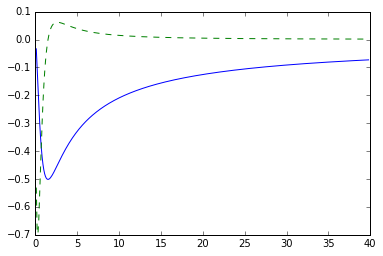

In [30]:
plt.plot(rs_array,ec(rs_array),"-",rs_array,vc(rs_array),"--")

### Exchange energy

In [31]:
rs_array=np.arange(drs,40,drs)
dx=0.001
xint=np.arange(dx,25,dx)
ex_vec=np.zeros(rs_array.size)
i=0
for rs_tmp in rs_array:
    ex_vec[i]=-0.5*np.sum(0.5*np.sinc(kF*xint/np.pi)**2*v(xint,rs_tmp))*dx
    i=i+1

In [32]:
vx_array=np.diff(ex_vec)/drs
rs_array=rs_array[0:-1]
vx=interp1d(rs_array,vx_array, kind='cubic')
ex=interp1d(rs_array,ex_vec[0:-1], kind='cubic')

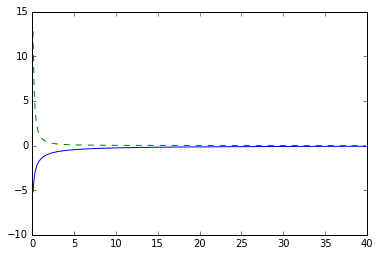

In [33]:
plt.plot(rs_array,ex_vec[0:-1],"-",rs_array,vx(rs_array),"--")

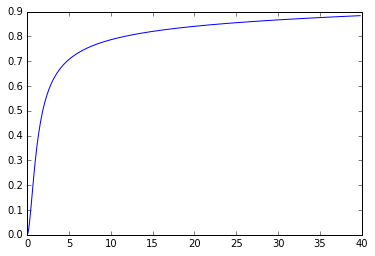

In [34]:
plt.plot(rs_array,ec(rs_array)/ex_vec[0:-1])

## The DFT selfconsistency loop

We are nearly finished. Now we collect everything and calculate the selfconsistent density. First we calculate the exchange correlation potential

In [35]:
def rs_rho(rho):
    res=rs/2/rho
    return res

In [36]:
Vxc=ex(rs_rho(rho))-vx(rs_rho(rho))*rs/rho/2 + ec(rs_rho(rho))-vc(rs_rho(rho))*rs/rho/2

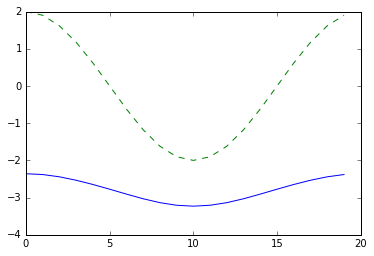

In [37]:
plt.plot(Vxc,"-",np.real(Vext),"--")

In [38]:
def VH(rho):
    "calculate the Hartree potential"
    res=np.zeros(nG)
    for ix in range(nG):
        for ixp in np.arange(-nG*nk/2,nG*nk/2):
            res[ix]=res[ix]+rho[int((ix-ixp)%nG)]*vper(ixp*a/nG)
    res=res*a/nG
    return res

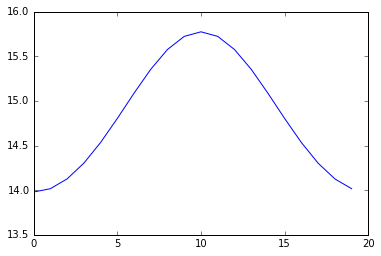

In [39]:
plt.plot(VH(rho),"-")

In [40]:
Vin=Vmat(VextG+FFT(VH(rho)+Vxc))

In [41]:
rho_old=rho

In the selfconsistenty cycle we need a mixing parameter in order to converge the result.

In [42]:
residual=np.array([1])
nmax=15
mix=0.4
rho_all=np.zeros((nmax+1,nG))
rho_all[0]=rho
i=0
while (residual[-1] >5e-4 and i<nmax):
    bandst,wfk=schroed(Vin)
    rho=rho*(1-mix)+mix*calc_rho(occ,wfk)
    Vxc=ex(rs_rho(rho))+rho*vx(rs_rho(rho)) + ec(rs_rho(rho))+rho*vc(rs_rho(rho))
    Vin=Vmat(VextG+FFT(VH(rho)+Vxc))
    i=i+1
    residual=np.append(residual,np.sum(np.abs(rho-rho_all[i-1]))/nG)
    rho_all[i]=rho

In [44]:
residual

array([  1.00000000e+00,   1.20684873e-02,   1.67550595e-02,
         6.99432727e-03,   2.93009406e-03,   1.22958768e-03,
         5.16427941e-04,   2.17015024e-04])

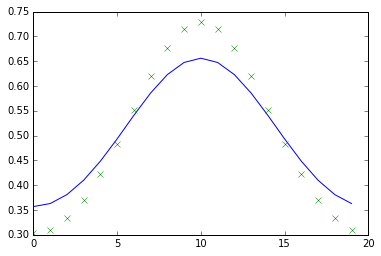

In [45]:
plt.plot(rho,"-",rho_old,'x')

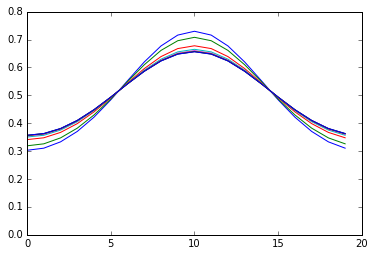

In [46]:
plt.plot(rho_all.T)

## Playground from here on

In [47]:
Vext=6*np.array([1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1])

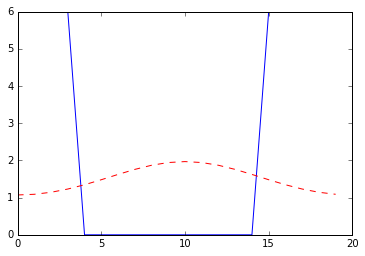

In [48]:
plt.plot(Vext,"-",np.imag(VextG),"-",3*rho,"--")

In [48]:
VextG=FFT(Vext)

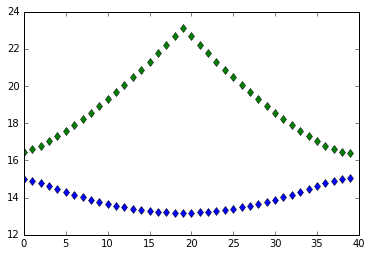

In [49]:
plt.plot(bandst[:,0:2],"d")